# 0. Clone Repo & Install Dependencies

In [1]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

# # Change the current working directory
# os.chdir('/content/drive/MyDrive/git/tensortrade-train')

# # Print the current working directory
# print("New working directory: {0}".format(os.getcwd()))

## 0.1 Clone/update repo

In [2]:
# if not os.path.isdir(os.getcwd()+'/.git'):
#   !git init && git remote add origin https://github.com/dennislwy/tensortrade-train.git && git pull origin master
# else:  # repo already exists, update it
#   !git pull origin master

## 0.2 Install dependencies
Check GPU availability

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
gpu_available = not (gpu_info.find('failed')>=0 or gpu_info.find('not recognized')>=0)
if gpu_available:
  print('GPU available')
  print(gpu_info)
else:
  print('GPU NOT available')
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')

GPU NOT available
Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


Install requirements

In [4]:
# ipywidgets is required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install it if required.

#!pip install ipywidgets

In [5]:
# if gpu_available:
#   print("Installing GPU requirement packages")
#   !pip install -r requirements.txt
# else:
#   print("Installing non-GPU requirement packages")
#   !pip install -r requirements.no-gpu.txt

## Imports

In [6]:
import ta

import pandas as pd
import numpy as np
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio
import tensortrade.env.default as default

%matplotlib inline

## Load Instruments

In [7]:
from tensortrade.oms.instruments import Instrument

TTC = Instrument("TTC", 8, "TensorTrade Coin")

## Data Preparation
### Load data

In [8]:
training_data_path = 'data/sine-fixed-15m-btc-usdt.csv'
testing_data_path = 'data/sine-fixed-15m-btc-usdt.csv'

In [9]:
# df = pd.read_csv(training_data_path)
# df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
# df['date'] = pd.to_datetime(df['date'])
# df.head()

In [10]:
amp = 50
offset = 100

# amp = 50
#offset = 30000

x = np.arange(0, 2 * np.pi, 2 * np.pi / 1001)
y = amp * np.sin(3 * x) + offset

df = pd.DataFrame()
df['close'] = y

### Create the dataset features

In [11]:
from ta.trend import *
from transform import difference, log_and_difference, max_min_normalize, mean_normalize

def add_indicators(df, fillna=False):    
    df['close_diff'] = difference(df['close'], inplace=False)
    df['close_log_diff'] = log_and_difference(df['close'], inplace=False)
    df['close_mean'] = mean_normalize(df['close'], inplace=False)
    
    df['macd_diff'] = macd_diff(df['close'], fillna=fillna)
    
    df['ema10'] = ema_indicator(df['close'], 10, fillna=fillna)
    df['ema25'] = ema_indicator(df['close'], 25, fillna=fillna)
    df['ema50'] = ema_indicator(df['close'], 50, fillna=fillna)

    df['ema25_50_diff'] = df['ema25']-df['ema50']
    df['ema25_50_diff_norm'] = 1-df['ema50']/df['ema25']
    df['trend_ema25_50'] = np.where(df['ema25_50_diff']>0, 1, -1)

    df['ema10_25_diff'] = df['ema10']-df['ema25']
    df['ema10_25_diff_norm'] = 1-df['ema25']/df['ema10']
    df['trend_ema10_25'] = np.where(df['ema10_25_diff']>0, 1, -1)

    df.dropna(axis=0, inplace=True)

    df.reset_index(drop=True, inplace=True)

In [12]:
add_indicators(df, fillna=False)

In [13]:
total_data_steps = len(df)
print(total_data_steps)

952


In [14]:
# import ta
# dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
# dataset.head(3)

### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [15]:
price_history = df[['close']]
display(price_history.head(3))

,close
0,139.861889
1,140.423161
2,140.970099


In [16]:
# price_history = df[['date', 'open', 'high', 'low', 'close', 'volume']]
# display(price_history.head(3))

In [17]:
# price_history = dataset[['date', 'open', 'high', 'low', 'close', 'volume']] 
# display(price_history.head(3))

# dataset.drop(columns=['date', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

<AxesSubplot:>

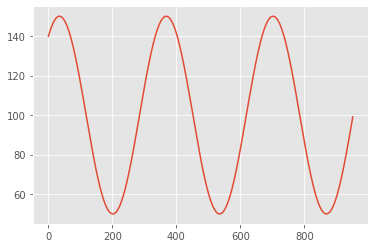

In [18]:
price_history['close'].plot(grid=True)

<AxesSubplot:>

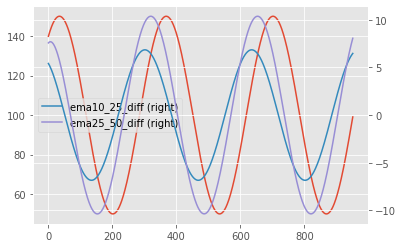

In [19]:
df['close'].plot(grid=True)
df['ema10_25_diff'].plot(grid=True, secondary_y=True, legend=True)
df['ema25_50_diff'].plot(grid=True, secondary_y=True, legend=True)

## Display & Inspect Price History

In [20]:
# !pip install mplfinance

In [21]:
# import mplfinance as mpf
# cd = df.copy()  

# # total data length in dataset
# data_length = len(cd)
# print(f"Total data length: {data_length}")

# Calculate Indicators

In [22]:
# cd.set_index('date', inplace=True)
# cd

# Plot Price History Chart

In [23]:
# #overlays = df[['ema25', 'ema50']]
# apds = [ 
#          #mpf.make_addplot(overlays, width=0.5), 
#          mpf.make_addplot(cd['emaNormDiff'], panel=2, width=0.5, ylabel='EMA\nNormalized\nDiff'),
#          mpf.make_addplot(cd['macd_diff'], panel=3, width=0.5, ylabel='MACD Diff'),
#        ]
# mpf.plot(cd, type='candle', 
#          style='charles', volume=True,
#          title='BTC/USD Full Data (%d steps)\n%s -> %s' % (data_length, cd.index[0], cd.index[data_length-1]), 
#          addplot=apds, figscale=1.2)

In [24]:
import matplotlib.pyplot as plt

def show_chart(df, columns1, columns2, columns3, title):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(title)

    df[columns1].plot(ax=axs[0], grid=True)
    df[columns2].plot(ax=axs[1], grid=True)
    df[columns3].plot(ax=axs[2], grid=True)

In [25]:
columns1 = ['close']
columns2 = ['ema10_25_diff', 'ema25_50_diff']
columns3 = ['close_diff', 'trend_ema10_25', 'trend_ema25_50', 'macd_diff']

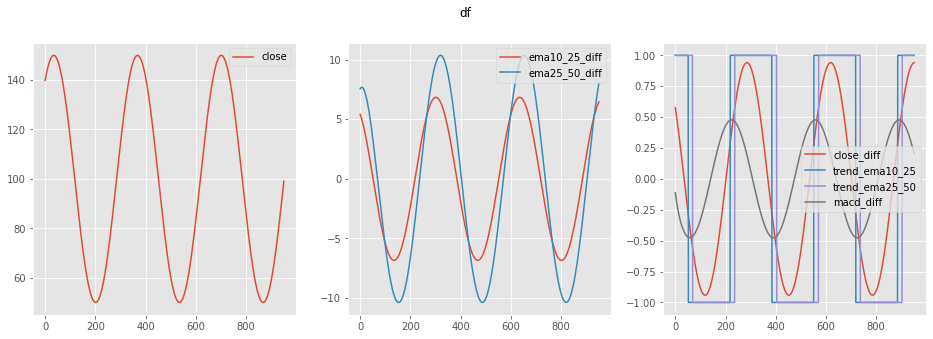

In [26]:
show_chart(df, columns1, columns2, columns3, 'df')

### Create Streams

In [27]:
# Setup stream based on 'Close'
close = Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-TTC")

### Create Data Feeds

In [28]:
# feed with all indicators
# with NameSpace("bitfinex"):
#     streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

# feed = DataFeed(streams)

In [29]:
# feed with custom indicators
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [30]:
feed = DataFeed([
    #Stream.source(df['close'].tolist(), dtype="float").rename("price"),
    #Stream.source(df['close'].tolist(), dtype="float").diff().fillna(0).rename("price_diff"),
    #Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("price_log_diff"),
    #Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),
    Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),

    #Stream.source(df['ema10_25_diff'].tolist(), dtype="float").rename("ema10_25_diff"),
    #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

    #Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
    Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),

    #Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff"),
])

In [31]:
feed.next()

{'close_diff': 0.5754065149617702, 'trend_ema25_50': 1}

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

In [32]:
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

chart_renderer = PlotlyTradingChart(
    display=True,  # show the chart on screen (default)
    height=800,  # affects both displayed and saved file height. None for 100% height.
    save_format="html",  # save the chart to an HTML file
    auto_open_html=True,  # open the saved HTML chart in a new browser tab
)

file_logger = FileLogger(
    filename="example.log",  # omit or None for automatic file name
    path="training_logs"  # create a new directory if doesn't exist, None for no directory
)

### Create Exchange & Portfolio

In [33]:
bitfinex = Exchange("bitfinex", service=execute_order)(
    close
)

initial_capital = 1000

cash = Wallet(bitfinex, initial_capital * USD)
asset = Wallet(bitfinex, 0 * TTC)

portfolio = Portfolio(USD, [
    cash,
    asset
])

### Reward & Action Scheme

In [34]:
# reward_scheme="risk-adjusted"
# action_scheme="managed-risk"

reward_scheme = default.rewards.PBR(price=close)
action_scheme = default.actions.BSH(cash=cash, asset=asset).attach(reward_scheme)

### Renderer Feed

In [35]:
# renderer_feed = DataFeed([
#     Stream.source(price_history[c].tolist(), dtype="float").rename(c) for c in price_history]
# )

In [36]:
renderer_feed = DataFeed([
    Stream.source(price_history['close'].tolist(), dtype="float").rename("price"),
    Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
])

In [37]:
# renderer_feed = DataFeed([
#     Stream.source(y, dtype="float").rename("price"),
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [38]:
# renderer_feed = DataFeed([
#     price,
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [39]:
# renderer_feed = DataFeed([
#     close
# ])

### Setup Environment

In [41]:
from PositionChangeChart import PositionChangeChart

window_size = 25

def create_env():
    env = default.create(
        feed=feed,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        window_size=window_size,
        max_allowed_loss=0.6
    )
    return env

In [42]:
!pip install dm-tree

  Using cached dm_tree-0.1.6-cp37-cp37m-win_amd64.whl (75 kB)


In [43]:
!pip install ray==0.8.7 ray[tune]==0.8.7 ray[rllib]==0.8.7 symfit

  Using cached ray-0.8.7-cp37-cp37m-win_amd64.whl (14.2 MB)
  Using cached symfit-0.5.3-py2.py3-none-any.whl
  Using cached click-8.0.1-py3-none-any.whl (97 kB)
  Using cached py_spy-0.3.7-py2.py3-none-win_amd64.whl (1.4 MB)
  Using cached redis-3.4.1-py2.py3-none-any.whl (71 kB)
  Using cached msgpack-1.0.2-cp37-cp37m-win_amd64.whl (68 kB)
  Using cached google-3.0.0-py2.py3-none-any.whl (45 kB)
  Using cached colorful-0.5.4-py2.py3-none-any.whl (201 kB)
  Using cached filelock-3.0.12-py3-none-any.whl (7.6 kB)
  Using cached gpustat-0.6.0-py3-none-any.whl
  Using cached opencensus-0.7.13-py2.py3-none-any.whl (127 kB)
  Using cached aioredis-1.3.1-py3-none-any.whl (65 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached opencv_python_headless-4.3.0.36-cp37-cp37m-win_amd64.whl (33.3 MB)
  Using cached lz4-3.1.3-cp37-cp37m-win_amd64.whl (192 kB)
  Using cached tensorboardX-2.4-py2.py3-none-any.whl (124 kB)
  Using cached atari_py-0.2.9-cp37-cp37m-win_amd64.whl (1.6 M

## Setup and Train Agent

In [ ]:
import ray
from ray import tune
from ray.tune.registry import register_env


register_env("TradingEnv", create_env)

analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 500
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2021-07-14 18:55:08,041	INFO resource_spec.py:231 -- Starting Ray with 3.37 GiB memory available for workers and up to 1.7 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-07-14 18:55:09,113	INFO services.py:1193 -- View the Ray dashboard at localhost:8265
(pid=15220) F0714 18:55:14.687863 15220  4248 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=15220) *** Check failure stack trace: ***
(pid=15220)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=15220)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=15220)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=15220)     @   00007FFD6B60780C  public: class std::ba

(pid=11376) F0714 18:55:15.113894 11376  1460 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=11376) *** Check failure stack trace: ***
(pid=11376)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=11376)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=11376)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=11376)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=11376)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1137

Trial name,status,loc
PPO_TradingEnv_f8486_00000,RUNNING,


2021-07-14 18:55:21,561	WARNING worker.py:1134 -- The actor or task with ID ffffffffffffffff45b95b1c0100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 8.000000}, {node:192.168.0.10: 1.000000}, {object_store_memory: 1.171875 GiB}, {memory: 3.369141 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
2021-07-14 18:55:21,787	INFO (unknown file):0 -- gc.collect() freed 64 refs in 0.12917889999999943 seconds
(pid=2392) F0714 18:55:44.652113  2392 14380 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker

(pid=5608) F0714 18:55:45.147153  5608 14764 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=5608) *** Check failure stack trace: ***
(pid=5608)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=5608)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=5608)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=5608)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=5608)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=5608)     @

(pid=14928) F0714 18:56:15.271417 14928  6304 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=14928) *** Check failure stack trace: ***
(pid=14928)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=14928)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=14928)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=14928)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=14928)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1492

(pid=15464) F0714 18:56:15.521435 15464 16308 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=15464) *** Check failure stack trace: ***
(pid=15464)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=15464)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=15464)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=15464)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=15464)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1546

(pid=11160) F0714 18:56:44.824120 11160  4284 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=11160) *** Check failure stack trace: ***
(pid=11160)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=11160)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=11160)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=11160)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=11160)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1116

(pid=12404) F0714 18:57:14.473121 12404 13344 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=12404) *** Check failure stack trace: ***
(pid=12404)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=12404)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=12404)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=12404)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=12404)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1240

(pid=12928) F0714 18:57:14.625138 12928 13716 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=12928) *** Check failure stack trace: ***
(pid=12928)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=12928)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=12928)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=12928)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=12928)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1292

(pid=15604) F0714 18:57:14.866151 15604 15416 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=15604) *** Check failure stack trace: ***
(pid=15604)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=15604)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=15604)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=15604)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=15604)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1560

(pid=11164) F0714 18:57:44.798280 11164 10628 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=11164) *** Check failure stack trace: ***
(pid=11164)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=11164)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=11164)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=11164)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=11164)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1116

(pid=10544) F0714 18:58:14.871055 10544 15540 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=10544) *** Check failure stack trace: ***
(pid=10544)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=10544)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=10544)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=10544)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=10544)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1054

(pid=8948) F0714 18:58:44.496915  8948 11544 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=8948) *** Check failure stack trace: ***
(pid=8948)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=8948)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=8948)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=8948)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=8948)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=8948)     @

(pid=11628) F0714 18:58:44.746934 11628 13476 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=11628) *** Check failure stack trace: ***
(pid=11628)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=11628)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=11628)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=11628)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=11628)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1162

(pid=9284)     @   00007FFD6C12554C  PyErr_NoMemory
(pid=9284)     @   00007FFD6C0E6FB7  Py_Main
(pid=9284)     @   00007FFD6C0E6F92  Py_Main
(pid=9284)     @   00007FF6E2131258  (unknown)
(pid=9284)     @   00007FFDD1DC7034  BaseThreadInitThunk
(pid=9284)     @   00007FFDD2EA2651  RtlUserThreadStart
(pid=2556) F0714 18:59:14.585594  2556  5780 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=2556) *** Check failure stack trace: ***
(pid=2556)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=2556)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=2556)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=2556)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct 

(pid=12044) F0714 18:59:44.546396 12044  9412 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=12044) *** Check failure stack trace: ***
(pid=12044)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=12044)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=12044)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=12044)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=12044)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=1204

(pid=8684) F0714 18:59:44.756927  8684 15364 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=8684) *** Check failure stack trace: ***
(pid=8684)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=8684)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=8684)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=8684)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=8684)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=8684)     @

(pid=7140) F0714 19:00:14.608446  7140  7948 core_worker.cc:317]  Check failed: assigned_port != -1 Failed to allocate a port for the worker. Please specify a wider port range using the '--min-worker-port' and '--max-worker-port' arguments to 'ray start'.
(pid=7140) *** Check failure stack trace: ***
(pid=7140)     @   00007FFD6B851B1B  public: void __cdecl google::LogMessage::Flush(void) __ptr64
(pid=7140)     @   00007FFD6B8508B2  public: __cdecl google::LogMessage::~LogMessage(void) __ptr64
(pid=7140)     @   00007FFD6B841268  public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=7140)     @   00007FFD6B60780C  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=7140)     @   00007FFD6B61BDFC  public: class std::basic_ostream<char,struct std::char_traits<char> > * __ptr64 __cdecl google::base::CheckOpMessageBuilder::ForVar1(void) __ptr64
(pid=7140)     @

(pid=11808)     @   00007FFD6C0CD00F  _PyObject_FastCallKeywords
(pid=11808)     @   00007FFD6C0CCE1A  _PyObject_FastCallKeywords
(pid=11808)     @   00007FFD6C0D541E  _PyMethodDef_RawFastCallKeywords
(pid=11808)     @   00007FFD6C0D5E02  _PyEval_EvalFrameDefault
(pid=11808)     @   00007FFD6C0BCDB6  _PyEval_EvalCodeWithName
(pid=11808)     @   00007FFD6C0D53EC  _PyMethodDef_RawFastCallKeywords
(pid=11808)     @   00007FFD6C0D654A  _PyEval_EvalFrameDefault
(pid=11808)     @   00007FFD6C0BCDB6  _PyEval_EvalCodeWithName
(pid=11808)     @   00007FFD6C0ABB67  PyEval_EvalCodeEx
(pid=11808)     @   00007FFD6C0ABAC5  PyEval_EvalCode
(pid=11808)     @   00007FFD6C0ABA6F  PyArena_Free
(pid=11808)     @   00007FFD6C235601  PyRun_FileExFlags
(pid=11808)     @   00007FFD6C235E28  PyRun_SimpleFileExFlags
(pid=11808)     @   00007FFD6C2354CF  PyRun_AnyFileExFlags
(pid=11808)     @   00007FFD6C1811D7  _Py_UnixMain
(pid=11808)     @   00007FFD6C18127F  _Py_UnixMain
(pid=11808)     @   00007FFD6C12554C

# Evaluate Agent

In [ ]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

## Direct Performance and Net Worth Plotting
Alternatively, the final performance and net worth can be displayed using pandas via Matplotlib.

In [ ]:
# def show_performance(df, price_history):
#     fig, axs = plt.subplots(1, 2, figsize=(15, 7))
#     fig.suptitle('Performance')

#     df.plot(ax=axs[0], grid=True, fontsize=12)
#     df.net_worth.plot(ax=axs[1], grid=True, legend=True)
#     price_history['close'].plot(ax=axs[1], secondary_y=True, legend=True)

#     plt.interactive(True)
#     plt.show(block=True)

In [ ]:
# performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
# performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
# show_performance(performance, price_history)

In [ ]:
# net_worth = performance.net_worth[len(performance.net_worth)-1]
# print(f"Net worth = {net_worth} USD")

# pnl = 100*(net_worth/initial_capital - 1)
# print(f"PNL = {pnl} %")

In [ ]:
#env.action_scheme.portfolio.performance